In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Project_1.ipynb
./.ipynb_checkpoints/Project_1-checkpoint.ipynb
./data/titanic.csv
./data/.ipynb_checkpoints/titanic-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Build an ML model to play the game Tetris automatically.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

Sample game code and basic algorithms were provided to us.

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

To explore the data, I played around with the given models to compares times and scores.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
genetic_base = [(0.73, 18), (0.52, 7, 0), (0.75, 22, 0)]
genetic_10 = [(2.14, 61), (2.49, 68), (1.85, 30)]
genetic_15 = [(3.89, 42), (158.97, 9012), (2.58, 31)]
genetic_25 = [(10.24, 329), (34.55, 1236), (8.20, 291)]
mcts = [(0.32, 8), (0.22, 8), (0.42, 9)]
greedy = [(7.68, 1267), (41.37, 6944), (12.60, 2167)]

In [15]:
times = {
    "genetic_base": [x[0] for x in genetic_base],
    "genetic_10": [x[0] for x in genetic_10],
    "genetic_15": [x[0] for x in genetic_15],
    "genetic_25": [x[0] for x in genetic_25],
    "mcts": [x[0] for x in mcts],
    "greedy": [x[0] for x in greedy],
}

df_times = pd.DataFrame(times)
print(df_times)

   genetic_base  genetic_10  genetic_15  genetic_25  mcts  greedy
0          0.73        2.14        3.89       10.24  0.32    7.68
1          0.52        2.49      158.97       34.55  0.22   41.37
2          0.75        1.85        2.58        8.20  0.42   12.60


In [16]:
score = {
    "genetic_base": [x[1] for x in genetic_base],
    "genetic_10": [x[1] for x in genetic_10],
    "genetic_15": [x[1] for x in genetic_15],
    "genetic_25": [x[1] for x in genetic_25],
    "mcts": [x[1] for x in mcts],
    "greedy": [x[1] for x in greedy],
}

df_scores = pd.DataFrame(score)
print(df_scores)

   genetic_base  genetic_10  genetic_15  genetic_25  mcts  greedy
0            18          61          42         329     8    1267
1             7          68        9012        1236     8    6944
2            22          30          31         291     9    2167


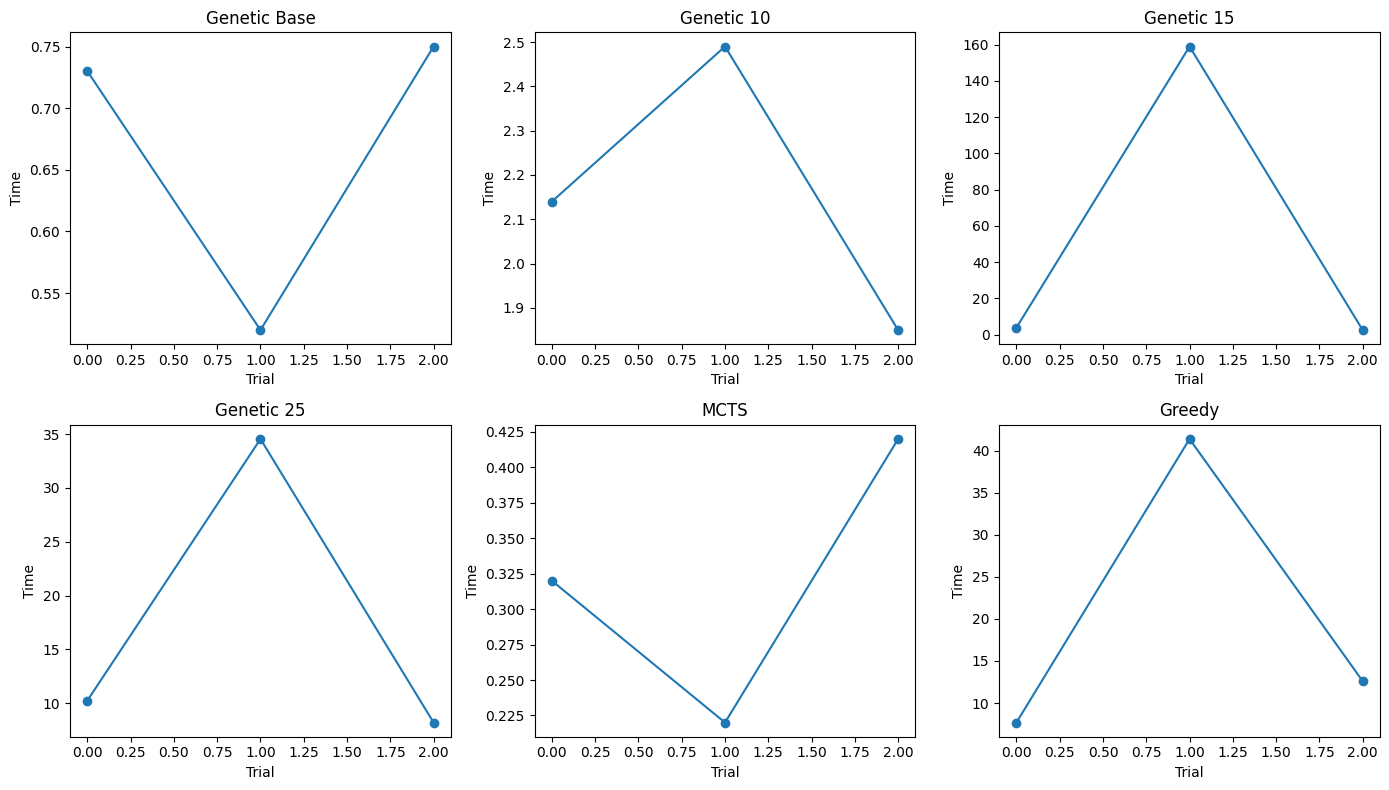

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

titles = ["Genetic Base", "Genetic 10", "Genetic 15", "Genetic 25", "MCTS", "Greedy"]

for i, col in enumerate(df.columns):
    axes[i].plot(df_times[col], marker='o')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Trial")
    axes[i].set_ylabel("Time")

plt.tight_layout()
plt.show()

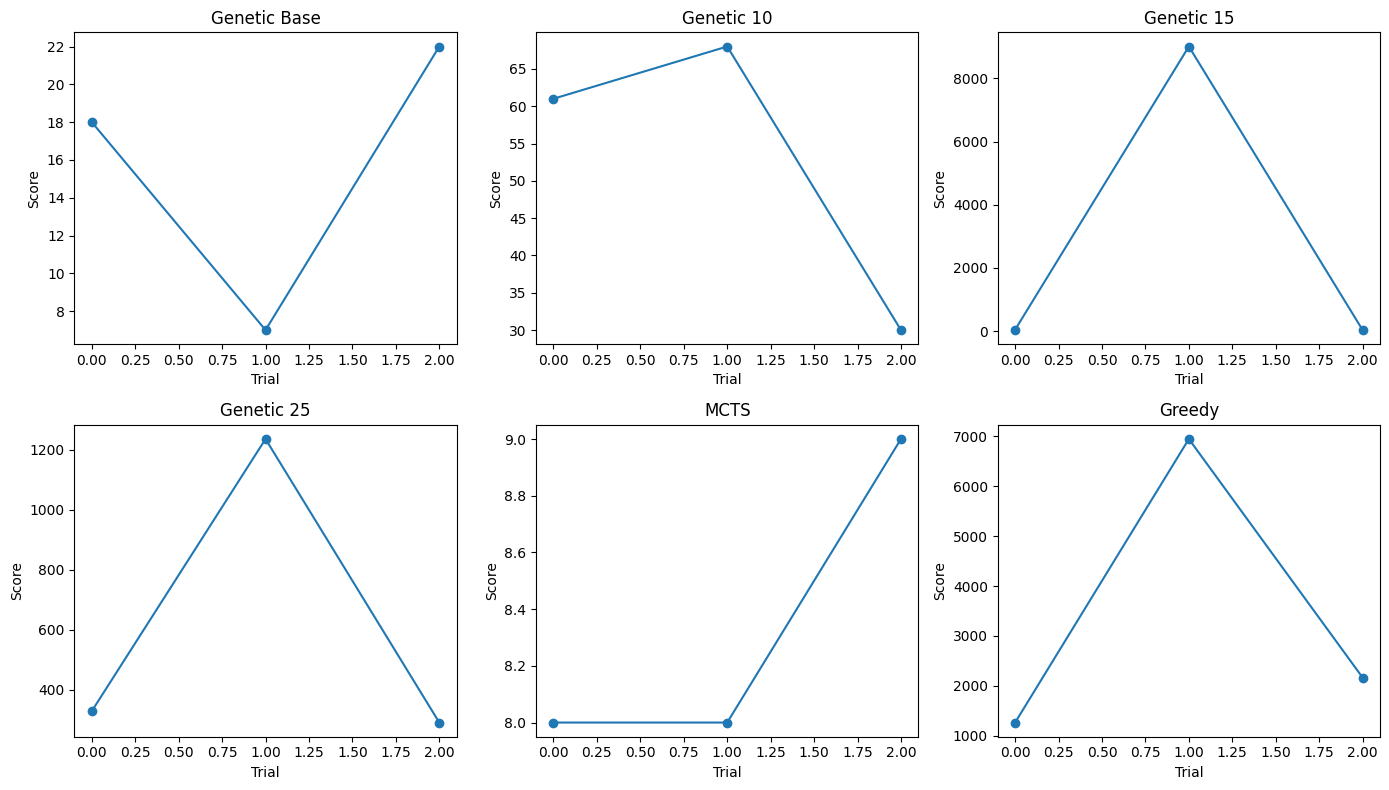

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

titles = ["Genetic Base", "Genetic 10", "Genetic 15", "Genetic 25", "MCTS", "Greedy"]

for i, col in enumerate(df.columns):
    axes[i].plot(df_scores[col], marker='o')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Trial")
    axes[i].set_ylabel("Score")

plt.tight_layout()
plt.show()

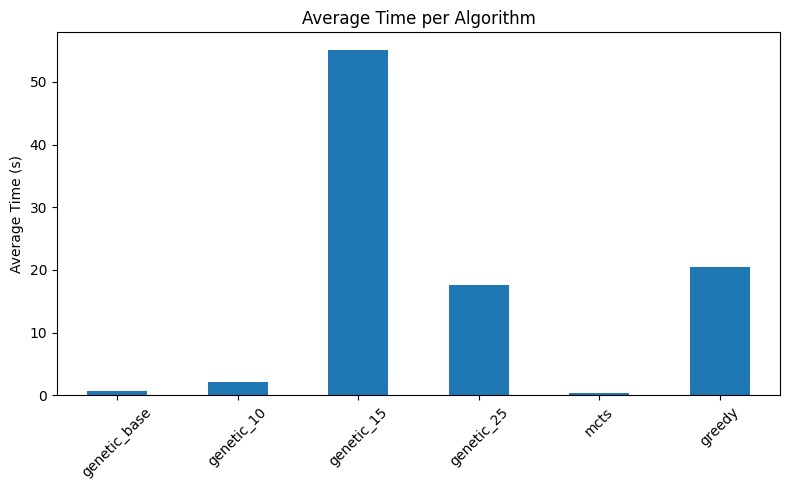

In [14]:
avg_times = df.mean()
plt.figure(figsize=(8, 5))
avg_times.plot(kind='bar', rot=45)
plt.ylabel("Average Time (s)")
plt.title("Average Time per Algorithm")
plt.tight_layout()
plt.show()

From this, I can see that these algorithms seem to have a big component of luck. I will go with the Genetic algorithm, though, because I can see the most potential for it if I add more rewards and attributes and I train for longer with a bigger population.

# 4.Prepare the Data


Apply any data transformations and explain what and why


I'm going to adapt the genetic algorithm to fit my needs and play for longer.

I'll do this by adding more attributes and training for longer.

Features to add:
- reward based on rows cleared or time, not score (would prioritize staying safe over playing risky to get a high score)
- find holes (find potential spots)
- find peaks (find potential issues)
- find the "bumpiness" of the rows (find best placement and rotation for blocks)
- find covered up spots (barricades) (negatively reward to make sure model is utilizing all space available)

After training, I realized I needed way more attributes:
- holes
- peaks
- bumpiness
- max peak
- barricades
- wells
- cleared
- column transition
- row transition
- landing height

In [21]:
def get_barricades(area):
    h, w = area.shape
    visited = np.zeros_like(area, dtype=bool)
    
    q = deque()

    for col in range(w):
        if area[0, col] == 0:
            q.append((0, col))
            visited[0, col] = True

    # BFS flood fill
    while q:
        r, c = q.popleft()
        for dr, dc in [(1,0),(-1,0),(0,1),(0,-1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < h and 0 <= nc < w:
                if not visited[nr, nc] and area[nr, nc] == 0:
                    visited[nr, nc] = True
                    q.append((nr, nc))

    # cells not reachable from top
    return np.sum((area == 0) & (~visited))

In [23]:
# count the number of lines cleared by the piece (if all cells r filled in that row)
def lines_cleared(area):
    cleared = 0
    for row in area:
        if np.all(row):
            cleared += 1
    return cleared

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


I've experimented with genetic and using the rows cleared as my main incentive for the model and pieces dropped.

## Experiment 1:

The model didn't do much, and I realized some of my code wasn't working well. The mutation rate was really low and the survival rate was low as well. The model wouldn't clear rows and survived for only fractions of a second.

## Experiment 2:

This model was also struggling. I starting playing around with values, but I realized the weights weren't working properly and the mutation was bugging out. My values were all really close to 0, so I instead played around with the range of weights I had set up and increased them as well as my number of trials and epochs.

## Experiment 3:

This is when I began to log my data consistently. However, my model hadn't improved much. There was little variability but I consistently got only about half a second of play time. I was still rewarding based on number of pieces dropped in this trial.

## Experiment 4:

Most of my data was similar to the last run. However, there was a lot more variability this time. Additionally, this time, I started saving my weights. The model had improved very slightly, but not by a lot. I wasn't sure if it was a problem with my attributes or my actual code at this moment, so I played around with the weights and changing the sign of the attributes to maybe weigh them differently.

## Experiment 5-6:

In these experiments, I thought that the trials and epochs were just taking too long, so I found a solution by using pooling to spread the work over multiple gpus. My progress was staying mostly the same, and the entire population seemed to not be explored that well, since the elite and top populations were about the same. This showed that I needed to increase the mutation rates.

## Experiment 7-8:

I finally switched my rewards to using line clears and I began to add a few more attributes (I had a total of 4). I got to the point where my models were surviving around 1.5 seconds on average, which is not bad. I was clearing about 4 rows and 30 points average. I also upped my epochs, trials, and populations since I could process more.

## Experiment 9:

I added another 2 attributes, which raised my average slightly to around 1.6 seconds, 40 points, and 7 rows cleared. In order to lower my variance, I increased the number of trials, and I raised the survival rate so more of my population would survive to hopefully encourage more improvement. 

## Experiment 10:

Finally, I added my final 4 attributes. My average skyrocketed to around 20 seconds, 500 points, and 300 rows cleared. There was a lot of variance, so I worked to fix it, but I was struggling with the variance. Sometimes my model was extremely accurate with thousands of rows cleared, and sometimes my model only cleared 100 rows. 

## Experiment 11:

I proceded with the past saved genotypes, but I lowered things like the mutation rate and survival rate to encourage more improvement rather than just pure random training. I also increased my epochs and trials to see how much I could push the training. However, while it was slowly increasing, there was still a ton of variability. However, the model was doing well so I just left it and continued to train as normal. 

## Experiment 12:

This is my final training code. I kept training based on this code until I got to an average I liked.

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [25]:
def inference():
    genotype = np.load("best_model.npy")
    agent = CUSTOM_AI_MODEL(genotype=genotype, mutate=False)

    game = Game('student', agent=agent)
    pieces_dropped, rows_cleared = game.run_no_visual()

    print("Rows cleared:", rows_cleared)
    print("Pieces dropped:", pieces_dropped)

In [ ]:
inference()